# Building a Neural Network with a Scalar Autograd Engine from Scratch

In this notebook I build a very simple neural network with backpropagation from scratch. The neural network is implemented using a series of interconnected layers and neurons to create a multi-layered perceptron. Backpropagation is implemented using a scalar valued autograd engine, which differs from more common backpropagation frameworks that use vectors. Mathematically, the principles of backpropagation remain consistent whether using scalars or vectors, but the use of scalars makes it easier to conceptualize and visualize. This project follows Andrej Karpathy's amazing YouTube video (https://youtu.be/VMj-3S1tku0?si=piw28IP2aMQDwRtf), with additional notes and minor adjustments.


### Project Objectives
- __Build Fundamental Blocks__: Develop classes for values, neurons, layers and the MLP that forms the neural network's architecture.
- __Implement Backpropagation__: Create a mechanism for backpropagation to enable the network to learn from data.
- __Test and Validate__: Use sample datasets to train the network and validate its learning capability.

***
## Value Class
The __'Value'__ class is a data structure that is designed to support neural network computations and automatic differentiation, and is the most crucial aspect of this project because it enables the backpropagation process. This class encapsulates several key components: 

- A numerical value resulting from an arithmetic operation
- The values of the operands involved in the operation
- The specific operation applied
- References to the operand objects

By storing not only the result of each operation but also references to the operands and the type of operation performed the Value class is able to create a computational graph, which is a networked data structure that represents the sequence of operations and interdependencies between variables and calculations. This computational graph is essential for backpropagation because it ensures the correct order of operations when traversing the nodes in the network.


### Supported Arithmetic Operations
- Addition
- Subtraction
- Multiplication
- Division
- Exponentiation   
- Negation

### Key Methods in Value Class
- __'tanh'__ Method: Applies the hyperbolic tangent function to the value, a common activation function in neural networks that introduces non-linearity. This method includes a backward function for calculating the gradient during backpropagation, essential for adjusting the network’s parameters.

- __'exp'__ Method: Executes the exponential function on the value. The exponential function is widely used in various neural network operations, such as normalization. Similar to the 'tanh' method, it defines a backward function for gradient computation, contributing to the effective training of the network.

- __'backward'__ Method: Facilitates the backward pass through the computational graph. This method is critical for backpropagation, as it computes the gradients for all Value objects in the graph. By traversing the graph in reverse topological order, it ensures that the gradients are calculated efficiently and accurately, enabling the optimization of the neural network’s weights and biases.

In [5]:
# Importing necessary libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Value:
    """
    The Value class represents a scalar value and is used for automatic differentiation.
    It stores data, gradient, and operation information for backpropagation.
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Constructor for the Value class.

        :param data: The numerical value (scalar).
        :param _children: Tuple of Value objects that are inputs to this Value object.
        :param _op: String representing the operation that produced this Value.
        :param label: An optional label for the value, useful for debugging.
        """
        self.data = data         # The actual data (a scalar) that this Value represents.
        self.grad = 0.0          # Gradient of this Value, used in backpropagation.
        self._backward = lambda: None  # Function to compute the backward pass (initially empty).
        self._prev = set(_children)    # Previous Value objects that lead to this one.
        self._op = _op           # Operation that produced this Value, for debugging.
        self.label = label       # Optional label for identifying the Value.

    def __repr__(self):
        """
        String representation of the Value object.
        """
        return f"Value(data={self.data})"
    
    # Below are the overridden arithmetic operators to enable operations between Value objects
    # or Value objects and scalars (numbers).

    def __add__(self, other):
        """
        Overloaded addition operator. Supports addition of two Value objects or a Value and a scalar.

        :param other: Value object or scalar to add.
        :return: New Value object representing the sum.
        """
        # Convert 'other' to Value if it's not, to support adding scalars to Value objects.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value object representing the sum.
        out = Value(self.data + other.data, (self, other), '+')
        
        # Define the backward function for this operation.
        def _backward():
            # Gradient update rule for addition.
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    # Similar methods are defined for other arithmetic operations like multiplication (*),
    # power (**), division (/), and subtraction (-).
    # Each method defines how to compute the forward operation and the backward pass for gradient computation.

    def __mul__(self, other):
        """
        Overloaded multiplication operator. Supports multiplication of two Value objects or a Value and a scalar.
        
        :param other: Value object or scalar to multiply with.
        :return: New Value object representing the product.
        """      
        # Convert 'other' to Value if it's not, to support multiplying scalars with Value objects.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value object representing the product.
        out = Value(self.data * other.data, (self, other), '*')
        
        # Define the backward function for this operation.
        def _backward():
          # Gradient update rule for multiplication.
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """
        Overloaded power operator. Raises the Value to the power of a given number.
        
        :param other: A scalar representing the exponent.
        :return: New Value object representing the power operation.
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        # Create a new Value object representing the power.
        out = Value(self.data**other, (self,), f'**{other}')
        
        # Define the backward function for this operation.
        def _backward():
          # Gradient update rule for power.
          self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # other * self
        """
        Right multiplication operator. Called for the reversed operand order in multiplication.
    
        :param other: Value object or scalar that multiplies the current object.
        :return: Result of the multiplication as a new Value object.
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Overloaded division operator. Divides the current Value by another Value or a scalar.
    
        :param other: Value object or scalar to divide by.
        :return: New Value object representing the division.
        """
        # Implement division using multiplication and reciprocal (power of -1).
        return self * other**-1

    def __neg__(self): # -self
        """
        Overloaded unary negation operator. Negates the current Value.
    
        :return: New Value object representing the negated value.
        """
        return self * -1

    def __sub__(self, other): # self - other
        """
        Overloaded subtraction operator. Subtracts another Value or scalar from the current Value.
    
        :param other: Value object or scalar to subtract.
        :return: New Value object representing the subtraction.
        """
        return self + (-other)

    def __radd__(self, other): # other + self
        """
        Right addition operator. Called for the reversed operand order in addition.
    
        :param other: Value object or scalar that adds to the current object.
        :return: Result of the addition as a new Value object.
        """
        return self + other

    def tanh(self):
        """
        Applies the hyperbolic tangent function to this Value.

        :return: New Value object after applying tanh.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        # Define the backward function for the tanh operation.
        def _backward():
            # Gradient update rule for tanh.
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        """
        Applies the exponential function to this Value.

        :return: New Value object after applying the exponential function.
        """
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        # Define the backward function for the exponential operation.
        def _backward():
            # Gradient update rule for exp.
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
  
    def backward(self):
        """
        Performs the backward pass through the computational graph.
        This method computes gradients for all Value objects in the graph.
        """
        topo = []  # List to store the topological order of Value objects.
        visited = set()  # Set to keep track of visited Value objects.

        # Function to build the topological order.
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0  # Seed the gradient of the output node.
        # Traverse the graph in reverse topological order to compute gradients.
        for node in reversed(topo):
            node._backward()


***
## Neuron Class

Each __Neuron__ in a neural network is like a mini-computer. It takes input, processes it, and passes the result through an activation function that determines the neuron's output. This neuron's output is then used as an input to all of the neurons in the following layer of the neural network, until the output layer is reached. The weights of these operations, which are adjustable parameters, determine how much influence each input has on each neuron's output.

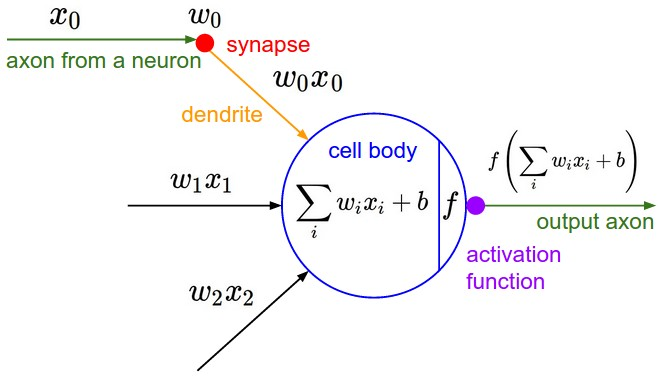

__The diagram illustrates the basic structure and function of a neuron in an artificial neural network:__

__Inputs (x0, x1, x2):__ These represent the signals or data received by the neuron. Each input is associated with a weight (w0, w1, w2), symbolizing the strength or influence of the input on the neuron's output.

__Weights (w0, w1, w2):__ The weights are depicted as being multiplied by the corresponding inputs. These are the adjustable parameters that the neural network learns during training.

__Synapse:__ The point where the weight is applied to the input, analogous to the synapses in biological neurons that transmit signals between neurons.

__Dendrite:__ The lines carrying the weighted inputs to the cell body can be thought of as dendrites, similar to the neural dendrites that convey electrical signals to a neuron's cell body.

__Cell Body:__ This is where the weighted inputs are summed together (Σwi * xi), along with a bias term (b), to form a weighted sum.

__Activation Function (f):__ The result of the weighted sum and bias is then passed through an activation function (f), which is a non-linear function that determines the neuron's output. The activation function is represented here as 'f'.

__Output Axon:__ The output of the activation function is then sent out through the neuron's output axon. This output becomes the input to subsequent neurons in the next layer of the network.


In [7]:

class Neuron:
    """
    This class represents a single neuron in a neural network.

    Attributes:
        w (list of Value): Weights of the neuron.
        b (Value): Bias of the neuron.
    """
    def __init__(self, nin):
        """
        Initializes a Neuron with a given number of input connections.

        :param nin: Number of input connections (integer).
        """
        # Initialize the weights (w) as random values between -1 and 1.
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # Initialize the bias (b) as a random value between -1 and 1.
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Activates the neuron with a given input.

        :param x: List of input values.
        :return: Output of the neuron after applying the activation function (tanh in this case).
        """
        # Compute the weighted sum of inputs and bias.
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # Apply the hyperbolic tangent activation function to the weighted sum.
        out = act.tanh()
        return out

    

    def parameters(self):
        """
        Retrieves all the parameters (weights and bias) of the neuron.

        This method is essential for optimization algorithms in neural networks,
        as it provides access to the parameters that need to be updated during
        the training process.

        :return: A list containing all the weights and the bias of the neuron.
        """
        # The method returns a list containing all the weights (self.w) 
        # and the bias (self.b). The '+' operator here is used to concatenate 
        # the list of weights with a list containing the single bias element.
        return self.w + [self.b]
        


***
## Layer Class

The __'Layer'__ class in the neural network is a data structure that encapsulates a collection of neurons. This class is initialized with a defined number of input and output neurons, which determines the size of the layer in the network. 

Upon activation with input data, each neuron in the layer processes the inputs using its unique set of weights and biases and then applies an activation function to generate an output. These neuron outputs are then assembled into an output vector that is then sent forward to the next layer. The diagram below depicts Input, Hidden, and Output layers in a basic network.

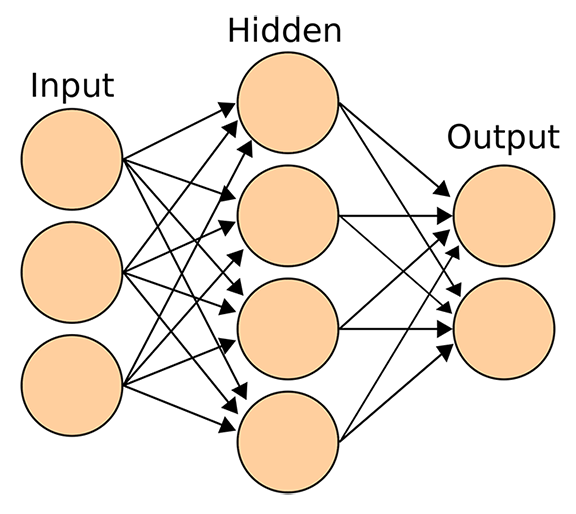

In [8]:
class Layer:
    """
    This class represents a layer in a neural network, containing multiple neurons.

    Attributes:
        neurons (list of Neuron): The neurons in this layer.
    """
    def __init__(self, nin, nout):
        """
        Initializes a Layer with a given number of input and output neurons.

        :param nin: Number of inputs each neuron in this layer should have.
        :param nout: Number of neurons in this layer.
        """
        # Create a list of neurons, each with 'nin' inputs.
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        """
        Activates the layer with a given input.

        :param x: List of input values.
        :return: Output of the layer (list of neuron outputs).
        """
        # Get the output of each neuron in the layer.
        outs = [n(x) for n in self.neurons]
        # If there's only one output, return just that, otherwise return the list of outputs.
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        """
        Retrieves the parameters (weights and biases) of all neurons in the layer.

        :return: A list of parameters (Value objects).
        """
        # Flatten and return the parameters from all neurons in the layer.
        return [p for neuron in self.neurons for p in neuron.parameters()]

***
## MLP (Multi-Layer Perceptron) Class

The __'MLP'__ (Multi-Layer Perceptron) class is where everything comes together to actually create the neural network. It orchestrates the interaction of values, neurons and layers, to process input data and generate outputs. As data flows through these layers, the MLP ensures that each neuron's output is correctly fed as input to the next layer, all the way until the final output is reached. This structure allows the network to learn and adapt from complex patterns in the data, with the MLP managing the overall data flow and learning process during training and prediction phases. 

Additionally, this is where the model training functionality is located. When training the MLP the user can input the size of the input vector, the size of the layers in the neural network, initialize the neural network with input data, adjust the learning rate and epoch count. 

In [9]:
class MLP:
    """
    This class represents a Multilayer Perceptron (MLP), a type of neural network.

    Attributes:
        layers (list of Layer): The layers in the MLP.
    """
    def __init__(self, nin, nouts):
        """
        Initializes an MLP with a given number of input neurons and a list of output neurons per layer.

        :param nin: Number of input neurons.
        :param nouts: List of integers, where each integer represents the number of neurons in a layer.
        """
        # Create layers based on the given sizes.
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        """
        Activates the MLP with a given input.

        :param x: List of input values.
        :return: Output of the MLP after passing through all layers.
        """
        # Pass the input through each layer in succession.
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        """
        Retrieves the parameters (weights and biases) of all layers in the MLP.

        :return: A list of parameters (Value objects).
        """
        # Flatten and return the parameters from all layers in the MLP.
        return [p for layer in self.layers for p in layer.parameters()]


    def train(self, xs, ys, learning_rate=0.05, epochs=10):
        """
        Trains the MLP neural network.
    
        :param xs: List of input vectors for training.
        :param ys: Corresponding list of target output values.
        :param learning_rate: The step size for updating the weights (default is 0.05).
        :param epochs: Number of training cycles through the entire dataset (default is 10).
        """
        for k in range(epochs):
            # Forward pass: Generate predictions
            ypred = [self(x) for x in xs]  # Evaluate the network for each input vector in 'xs'
    
            # Compute the loss: Mean Squared Error (MSE)
            loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  
    
            # Reset gradients to zero before backpropagation
            for p in self.parameters():
                p.grad = 0.0  # Set gradient of each parameter to zero to avoid accumulation
    
            # Backward pass: Compute gradients
            loss.backward()  # Perform backpropagation to calculate gradients of the loss
    
            # Update parameters: Gradient Descent
            for p in self.parameters():
                p.data += -learning_rate * p.grad  # Adjust each parameter opposite to its gradient direction
    
            # Conditional printing for tracking progress
            if epochs > 49 and k % 10 == 0:
                # Print loss every 10 iterations if there are more than 49 epochs
                print(f"Iteration {k}, Loss: {loss.data}")
            elif epochs <= 49:
                # Print loss for every iteration if total epochs are 49 or less
                print(f"Iteration {k}, Loss: {loss.data}")
    
        # Post-training: Output final predictions
        ypred_data = [round(y.data, 3) for y in ypred]  # Round off the predicted outputs for readability
    
        # Print the target and predicted values for comparison
        print("-------------------------------------------------------------")
        print("Target values: ", ys)
        print("Predicted values: ", ypred_data)

    def predict(self, x):
        return self(x)

***
## Computational Graphing Functions

In order to visualize the computational graph of the neural network and the backpropagation process two functions were created, __trace__ and __draw dot__.

__trace__ recursively explores the computational graph from a given root node, collecting all the nodes and their connections (edges) into sets. 

__draw dot__  uses these sets of nodes and edges to construct a visual graph using Graphviz, a graph visualization software. It creates a Digraph object, with nodes representing the operations and values (including data and gradients), and edges depicting the connections between these nodes. 

In [10]:
from graphviz import Digraph

def trace(root):
    """
    Builds a set of all nodes and edges in the computational graph starting from a given root node.

    :param root: The root node (usually the final output Value of the computation).
    :return: A tuple containing two sets, one of nodes and the other of edges in the graph.
    """
    nodes, edges = set(), set()

    def build(v):
        """
        Recursively traverses the graph to build sets of nodes and edges.

        :param v: Current Value node in the graph.
        """
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Creates a graphical representation of the computational graph using Graphviz.

    :param root: The root node of the computational graph.
    :return: A Graphviz Digraph object representing the graph.
    """
    # Initialize a Digraph object, setting the graph direction from left to right (LR).
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # Get the nodes and edges from the computational graph.
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For each Value node, create a rectangular ('record') node with its data and gradient.
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this node is the result of an operation, create a separate node for the operation.
            dot.node(name=uid + n._op, label=n._op)
            # Connect the operation node to the Value node.
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect each node to the operation node of its child in the graph.
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


***
## Simple Backpropagation Visualizations
In this section, we will visualize the backpropagation process with a very simple example. We will build a rudimentary neuron by initializing input values and their associated weights, adding a bias, and applying an activation function to simulate the neuron's output. Then, we will demonstrate backpropagation by calculating gradients for each parameter to understand their influence on the neuron's output. This process involves applying the chain rule of calculus to propagate gradients backward through the network, starting at the root node. For each parameter, __the gradient indicates how much a small change would affect the final output.__

In [11]:
# inputs x1, x2
x1 = Value(2.0, label='x1')  # Initialize input value x1 with 2.0 and label it 'x1'
x2 = Value(0.0, label='x2')  # Initialize input value x2 with 0.0 and label it 'x2'

# weights w1, w2
w1 = Value(-3.0, label='w1')  # Initialize weight w1 with -3.0 and label it 'w1'
w2 = Value(1.0, label='w2')   # Initialize weight w2 with 1.0 and label it 'w2'

# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Initialize the bias b and label it 'b'

# Perform the neuron's weighted input calculations
x1w1 = x1 * w1  # Multiply x1 with w1
x1w1.label = 'x1*w1'  # Label the result of x1*w1
x2w2 = x2 * w2  # Multiply x2 with w2
x2w2.label = 'x2*w2'  # Label the result of x2*w2

# Sum the weighted inputs
x1w1x2w2 = x1w1 + x2w2  # Add x1w1 and x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'  # Label the sum of x1w1 and x2w2

# Compute the neuron's total input by adding the bias
n = x1w1x2w2 + b  # Add the bias b to x1w1x2w2
n.label = 'n'  # Label the total input to the neuron

# Apply the tanh activation function
o = n.tanh()  # Apply tanh activation function to the neuron's total input
o.label = 'o'  # Label the output of the tanh function

# Perform backpropagation to compute gradients
o.backward()  # This populates the .grad attribute of all involved Value objects

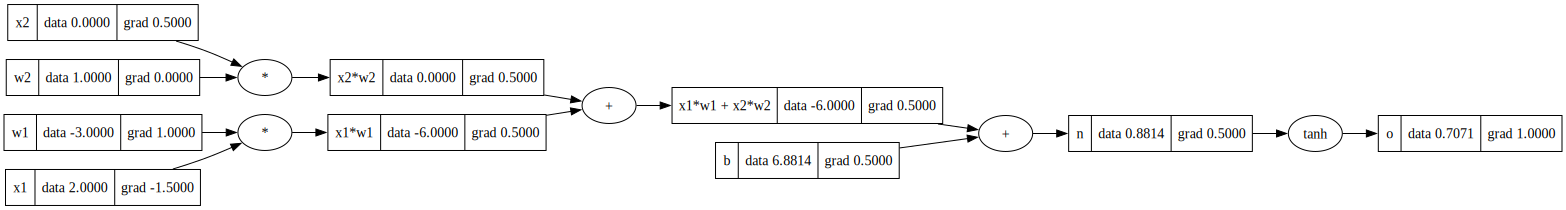

In [12]:
draw_dot(o)

Below we expand this example by explicitly calculating the tanh activation function for our neuron's output. We start with the same setup of inputs, weights, and bias, but instead of using a built-in function, we manually compute the tanh using its mathematical formula. After applying backpropagation to find the gradients, we visualize the process with a computational graph, providing a clear illustration of the neuron's operations and the gradient flow. Because we implemented the activation function manually we are able to see the gradients within the function as well, providing a glimpse of what goes on in the background. For a sanity check, we can confirm that our calculated gradients are the same in both examples.

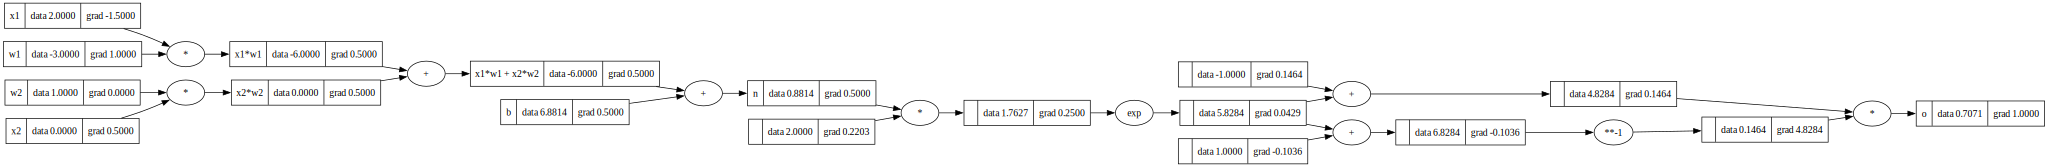

In [20]:
# inputs x1, x2
x1 = Value(2.0, label='x1')  # Initialize input value x1 with 2.0 and label it 'x1'
x2 = Value(0.0, label='x2')  # Initialize input value x2 with 0.0 and label it 'x2'

# weights w1, w2
w1 = Value(-3.0, label='w1')  # Initialize weight w1 with -3.0 and label it 'w1'
w2 = Value(1.0, label='w2')   # Initialize weight w2 with 1.0 and label it 'w2'

# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Initialize the bias b and label it 'b'

# Perform the neuron's weighted input calculations
x1w1 = x1 * w1  # Multiply x1 with w1 and label the result
x1w1.label = 'x1*w1'
x2w2 = x2 * w2  # Multiply x2 with w2 and label the result
x2w2.label = 'x2*w2'

# Sum the weighted inputs
x1w1x2w2 = x1w1 + x2w2  # Add x1w1 and x2w2 and label the sum
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Compute the neuron's total input by adding the bias
n = x1w1x2w2 + b  # Add the bias b to x1w1x2w2 and label the total input
n.label = 'n'

# -------
# Explicit computation of the hyperbolic tangent function
e = (2 * n).exp()  # Calculate the exponential of 2 times the neuron input
o = (e - 1) / (e + 1)  # Compute tanh using the formula: (exp(2x) - 1) / (exp(2x) + 1)
# -------

o.label = 'o'  # Label the output of the tanh function

# Perform backpropagation to compute gradients
o.backward()  # This populates the .grad attribute of all involved Value objects

# Visualization of the computational graph
# draw_dot function creates a visual representation of the computational graph
graph = draw_dot(o)
graph  # This will display the graph in Jupyter Notebook


***
## Testing Neural Network

In [21]:
# input vector consisting of three scalar values.
x = [2.0, 3.0, -1.0]

# Creating an instance of the MLP class
# The first argument specifies that the input layer has 3 neurons (matching the size of 'x').
# The list [4, 4, 1] defines the architecture of the neural network 
n = MLP(3, [4, 4, 1])

# Activating the MLP with the input vector
n(x)


# List of input vectors
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Defining the target outputs
ys = [1.0, -1.0, -1.0, 1.0]


In [22]:
n.train(xs, ys, .05, 100)

Iteration 0, Loss: 4.566131929126204
Iteration 10, Loss: 0.14682698134796965
Iteration 20, Loss: 0.055738899720270046
Iteration 30, Loss: 0.033103755267393856
Iteration 40, Loss: 0.02317735622059516
Iteration 50, Loss: 0.017682527348411338
Iteration 60, Loss: 0.014220846156541669
Iteration 70, Loss: 0.01185195590268967
Iteration 80, Loss: 0.010134822740379612
Iteration 90, Loss: 0.008836210337924033
-------------------------------------------------------------
Target values:  [1.0, -1.0, -1.0, 1.0]
Predicted values:  [0.961, -0.972, -0.948, 0.946]
